>**Alumnos**: *Adrián Ogáyar Sanchez y Arturo Barbero Pérez*

>**Grupo**: *11*

# Regresión lineal regularizada: sesgo y varianza

El objetivo de esta práctica es comprobar los efectos del sesgo y la varianza.
Para esto aplicaremos regresión lineal regularizada para aprender una hipótesis sesgada, que no es capaz de
clasificar correctamente a los ejemplos de entrenamiento, y a continuación usaremos de nuevo la
regresión lineal para sobre-ajustar los datos de entrenamiento a un polinomio de grado superior.

Comenzamos importando las librerías necesarias. Todas ellas han sido utilizadas y explicadas en prácticas anteriores.

In [1]:
from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp

## Regresión lineal regularizada

Continuamos cargando los datos del fichero *ex5data1.mat* Este fichero contiene una serie de datos de entrenamiento, datos de validación y datos de prueba. Estos datos de prueba consisten en la cantidad de agua derramada en una presa ($X$) en base a los cambios en el nivel del agua ($y$)

In [2]:
data = loadmat('ex5data1.mat')

X = data['X']
y = data['y']
Xtest = data['Xtest']
ytest = data['ytest']
Xval = data['Xval']
yval = data['yval']

print(X.shape)
print(y.shape)
print(Xval.shape)
print(yval.shape)

(12, 1)
(12, 1)
(21, 1)
(21, 1)


Tras cargar los datos debemos crear una función para calcular el coste y el gradiente de la regresión lineal regularizada que siguen esta expresión:
$$J(\theta)=\frac{1}{2m}(\sum^m_{i=1}(h_\theta(x^{(i)})-y^{(i)})^2)+\frac{\lambda}{2m}(\sum^n_{j=1}\theta^2_j)$$
$$\frac{\delta J(\theta)}{\delta\theta_0}=\frac{1}{m}\sum^m_{i=1}(h_\theta(x^{(i)})-y^{(i)})x^{(i)}_j\quad para\: j = 0$$
$$\frac{\delta J(\theta)}{\delta\theta_0}=\frac{1}{m}\sum^m_{i=1}(h_\theta(x^{(i)})-y^{(i)})x^{(i)}_j+\frac{\lambda}{m}\theta_j\quad para\: j\ge 1$$

In [3]:
h = lambda x, t : x.dot(t)

def coste(x, y, theta) :   
    return 1/(2*len(x)) * (np.sum(np.square(h(x, theta)-y)))

def costeReg(x, y, theta, lamb) :
    return coste(x,y,theta) + lamb/(2*len(x))*np.sum(np.square(theta[1:]))

def gradiente(theta, x, y, lamb) :
    grad = 1/len(x) * x.T.dot((h(x, theta)-y))
    grad[1:] += theta[1:]*lamb/len(x)
  
    return grad

def regLinealReg(theta, x, y, lamb) :
    y = y.ravel()
    one = np.ones((x.shape[0],1))
    x = np.hstack([one, x])
    return(costeReg(x,y,theta,lamb), gradiente(theta,x,y,lamb))

In [4]:
theta = np.ones((2,))
regLinealReg(theta, X, y, 1)

(303.9931922202643, array([-15.30301567, 598.25074417]))

Una vez tenemos la función de coste y gradiente podemos usar el ***minimize*** de la librería *scipy.optimize* para obtener el conjunto de $\theta s$  que dan lugar a la recta de regresión lineal.

In [5]:
thetaOpt = opt.minimize(regLinealReg, theta, args = (X, y, 0), method='TNC', jac=True)['x']
thetaOpt

array([13.08790394,  0.36777923])

Para mostrar esta recta definimos una función ***graficarDatos*** (una modificación de la misma usada en la práctica 1) y usamos las $\theta s$ obtenidas.

In [6]:
def graficarDatos(x, y, theta):
    h = lambda x: theta[0] + theta[1]*x
    
    #Establece unos maximos y minimos para los ejes
    ax = plt.gca()
    ax.axis([x.min() - 5, x.max() + 5, y.min() - 10, y.max() + 5])

    #Grafica la recta
    plt.plot([x.min(), x.max()], [h(x.min()), h(x.max())], '-b')

    #Grafica los datos
    plt.plot(x, y, 'rx')
    plt.xlabel('Cambio en nivel del agua')
    plt.ylabel('Agua derramada fuera de la presa')
    
    plt.show()
    
    return

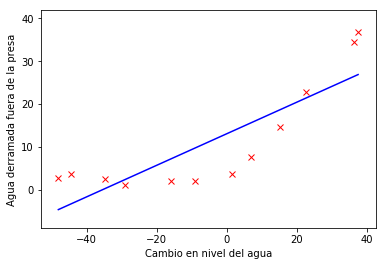

In [7]:
graficarDatos(X, y, thetaOpt)

## Curvas de Aprendizaje

La hipótesis elegida en el apartado anterior, una recta, es demasiado simple para ajustarse a los ejemplos de entrenamiento y por ello predice valores sesgados a la recta. Cuando los ejemplos vienen dados por más atributos no es posible tener una representación gráfica tan evidente. Por ello, se utilizan las curvas de aprendizaje para identificar situaciones de sub-ajuste (sesgo) o de sobre-ajuste (varianza).

Para generar las curvas de aprendizaje, tenemos que repetir el entrenamiento por regresión lineal del apartado anterior utilizando diferentes subconjuntos de los datos de entrenamiento. 

Una vez realizado el entrenamiento para ajustarse al subconjunto X[0:i] e y[0:i], tenemos que evaluar el error del resultado aplicado a ese mismo subconjunto, así como el error al clasificar a todos los ejemplos del conjunto de validación (Xval e yval). 

In [8]:
def curvaAprendizaje(x, y, xval, yval, reg):
    trainError = np.zeros((len(x), 1))
    validationError = np.zeros((len(x), 1))
    
    for i in range(1, len(x) + 1):
        theta = np.ones((x.shape[1] + 1,))
        thetaOpts = opt.minimize(regLinealReg, theta, args = (x[0:i], y[0:i], reg), method='TNC', jac=True)
        thetaOpts = thetaOpts['x']
  
        trainError[i-1] = regLinealReg(thetaOpts, x[0:i], y[0:i], 0)[0]
 
        validationError[i-1] = regLinealReg(thetaOpts, xval, yval, 0)[0]

    return (trainError, validationError)

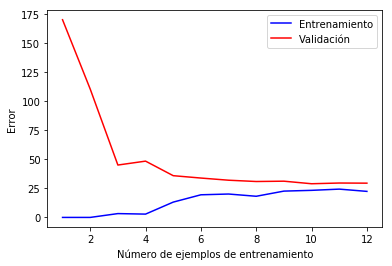

In [9]:
train_e, validation_e = curvaAprendizaje(X, y, Xval, yval, 0)
plt.plot(np.arange(1, len(X) + 1), train_e, 'b', label = 'Entrenamiento')
plt.plot(np.arange(1, len(X) + 1), validation_e, 'r', label = 'Validación')
plt.xlabel('Número de ejemplos de entrenamiento')
plt.ylabel('Error')
plt.legend(loc=0)

## Regresión polinomial

Para obtener un mayor ajuste a los datos de entrenamiento usaremos como hipótesis un polinomio de la entrada $x$:
$$h(x)=\theta_0+\theta_1x+\theta_2x^2+...+\theta_{p-1}x^{p-1}+\theta_px^p$$
Comenzaremos definiendo una función ***polinomizar*** que se encargue de devolvernos esos valores $x,x^2,...,x^p$ para un vector de valores y una $p$ dados.

In [10]:
def polinomizar(x, p) :
    return skp.PolynomialFeatures(p,include_bias=False).fit_transform(x)

Dado que los valores devueltos por la función serán de órdenes de magnitud muy distintos en cada una de sus columnas es necesario normalizar las columnas de modo que tengan una media de 0 y una desviación de 1.

In [11]:
def normalizar(x) :
    mu = np.mean(x,0)
    s = np.std(x,0)
    
    x = (x-mu)/s
    
    return (x, mu, s)

Polinomizamos los valores de entrada $X$ con una $p$ igual a $8$ y la normalizamos guardando la matriz normalizada, $\mu$ y $S$ en la variable *p*.

Con la matriz normalizada y unas $\theta s$ inicializadas a $0$ ejecutamos la función ***minimize*** para obtener las $\theta s$ óptimas.

In [12]:
p = polinomizar(X,8)
p = normalizar(p)
theta = np.zeros((p[0][0].size+1,))
thetaOpt = opt.minimize(regLinealReg, theta, args = (p[0], y, 0), method='TNC', jac=True)['x']

Para representar la gráfica de la función generamos una linea de puntos entre los puntos extremos de X (tomaremos un poco más de los extremos para ver su evolución), los polinomizamos y normalizamos con los valores $\mu$ y $S$ que obtuvimos en la normalización de $X$, y se calcula los *puntosY* mediante la función $h_\theta(x)$ con las $\theta s$ óptimas.

In [13]:
pX = np.arange(X.min() - 5, X.max() + 5, 0.05)
poly = polinomizar(pX.reshape(-1,1), 8)
poly = (poly-p[1])/p[2]
one = np.ones((poly.shape[0],1))
poly = np.hstack([one, poly])

puntosY = h(poly,thetaOpt)

In [14]:
def graficarDatosPoly(x, y, pX, pY):    
    #Establece unos maximos y minimos para los ejes
    ax = plt.gca()
    
    #Grafica los datos
    plt.plot(x, y, 'rx')
    plt.plot(pX, pY, '-b')
    plt.xlabel('Cambio en nivel del agua')
    plt.ylabel('Agua derramada fuera de la presa')
    ax.axis([pX.min()-5, pX.max()+2, pY.min()-10, pY.max()+5])
    plt.show()
    
    return

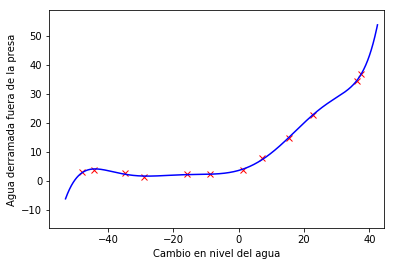

In [15]:
graficarDatosPoly(X, y, pX, puntosY)

In [16]:
def graficarCurvaAprendizaje(x, y, xval, yval, lamb) :
    ax = plt.gca()
    
    train_e, validation_e = curvaAprendizaje(x, y, xval, yval, lamb)
    ax.axis([0, len(p[0]) + 1, min(train_e.min(), validation_e.min())-5, max(train_e.max(), validation_e.max())+5])
    plt.plot(np.arange(1, len(p[0]) + 1), train_e, 'b', label = 'Entrenamiento')
    plt.plot(np.arange(1, len(p[0]) + 1), validation_e, 'r', label = 'Validación')
    plt.title(r'Curva de aprendizaje de regresión lineal ($\lambda$='+str(lamb)+')')
    plt.xlabel('Número de ejemplos de entrenamiento')
    plt.ylabel('Error')
    plt.legend(loc=0)

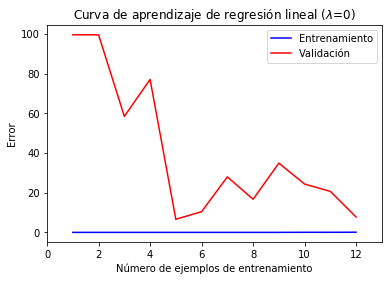

In [17]:
poly_Xval = polinomizar(Xval, 8)
poly_Xval = (poly_Xval-p[1])/p[2]

graficarCurvaAprendizaje(p[0], y, poly_Xval, yval, 0)

Como podemos comprobar, con $\lambda = 0$, tenemos que el error para los ejemplos de entrenamiento es 0. Es decir, se ajusta perfectamente a ellos. Sin embargo, con los ejemplos de validación vemos que el coste va variando y no llega a ser tan bajo como los de entrenamiento. Esto nos esta indicando que hay un claro sobre-ajuste en el modelo, no permitiendo de esta manera que se generalice bien la predicción para nuevos datos.

Veamos que ocurre con $\lambda = 1$:

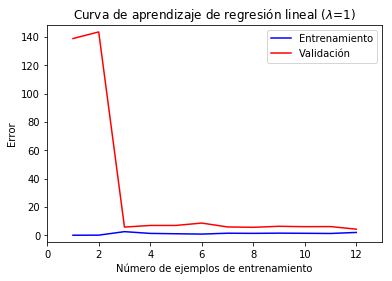

In [18]:
graficarCurvaAprendizaje(p[0], y, poly_Xval, yval, 1)

En este caso los ejemplos de entrenamiento siguen teniendo un error muy bajo, pero podemos comprobar además, que los de validación comienzan a tener un coste bastante bajo también cuantos más ejemplos de entrenamiento proporcionemos. Con $\lambda = 1$ el modelo se ajusta bastante bien.

Veamos que ocurre ahora con una lambda más alta, por ejemplo, $\lambda = 100$:

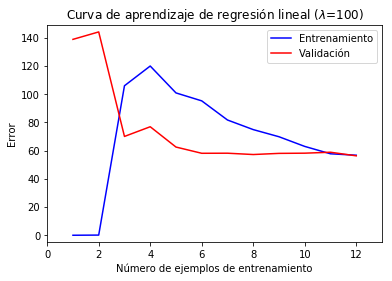

In [19]:
graficarCurvaAprendizaje(p[0], y, poly_Xval, yval, 100)

Cuando tenemos una lambda muy alta, podemos ver que el modelo tiene un sub-ajuste. El coste de los datos de entrenamiento va aumentando cuantos más ejemplos se proporcionan y luego comienza a decrecer, pero igualmente el coste para estos sigue siendo bastante alto en su punto más bajo.
Los ejemplos de validación hacen justo lo contrario.
Por tanto, llegamos a la conclusión de que utilizar una lambda muy alta no es nada conveniente.

## Selección del parámetro $\lambda$

In [20]:
lambdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
trainError = np.zeros((len(lambdas), 1))
validationError = np.zeros((len(lambdas), 1))

for i in range(0, len(lambdas)):
        theta = np.ones((p[0].shape[1] + 1,))
        thetaOpts = opt.minimize(regLinealReg, theta, args = (p[0], y, lambdas[i]), method='TNC', jac=True)['x']
  
        trainError[i] = regLinealReg(thetaOpts, p[0], y, 0)[0]
        validationError[i] = regLinealReg(thetaOpts, poly_Xval, yval, 0)[0]

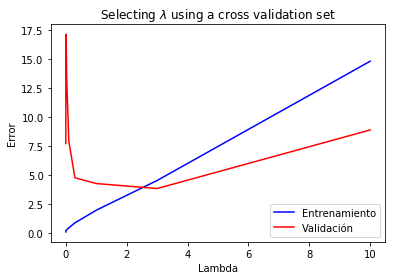

In [21]:
plt.plot(lambdas, trainError, 'b', label = 'Entrenamiento')
plt.plot(lambdas, validationError, 'r', label = 'Validación')
plt.title(r'Selecting $\lambda$ using a cross validation set')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.legend(loc=0)

In [22]:
lamb = np.argmin(trainError - validationError)
poly_Xtest = polinomizar(Xtest, 8)
poly_Xtest = (poly_Xtest-p[1])/p[2]

theta = np.ones((poly_Xtest.shape[1] + 1,))
thetaOpts = opt.minimize(regLinealReg, theta, args = (p[0], y, lamb), method='TNC', jac=True)['x']

trainError = regLinealReg(thetaOpts, poly_Xtest, ytest, 0)[0]
trainError

3.5720165560101833